In [ ]:
from random import shuffle
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import json
import os
from PIL import Image
import random

In [ ]:
# Load psg.json file
with open('./psg/psg.json') as json_file:
    json_data = json.load(json_file)
# Load word_categorized.json file - This is a category (presented below) file used for split of user datasets.
# You can check the categories in github.
with open('word_categorized.json') as json_file:
    word_cate = json.load(json_file)

In [ ]:
set_test_idx = set(json_data["test_image_ids"])

train_data = []
test_data = []

for d in json_data["data"]:
    if d['image_id'] not in set_test_idx:
        train_data.append(d)
    else:
        test_data.append(d)

# Combine thing and stuff lists
psg_thing_cats = json_data['thing_classes']
psg_stuff_cats = json_data['stuff_classes']
psg_obj_cats = psg_thing_cats + psg_stuff_cats

def categorize_list(input_list, category_dict):
    categorized_list = []
    for item in input_list:
        found = False
        for category, subcategories in category_dict.items():
            if item in subcategories:
                categorized_list.append(list(category_dict.keys()).index(category))
                found = True
                break
        if not found:
            categorized_list.append(None)
    return categorized_list

obj_super_list = categorize_list(psg_obj_cats, word_cate['categories'])
pred_super_list = categorize_list(json_data['predicate_classes'], word_cate['relations'])

In [ ]:
# Generate category matrix using the combined object list.
cate_matrix = []
for i in train_data:
    mat_info = []
    seg = i['segments_info']

    for m in i['relations']:
        super_cat_info = [0, 0, 0]

        super_cat_info[2] = pred_super_list[m[2]]
        super_cat_info[0] = obj_super_list[seg[m[0]]['category_id']]
        super_cat_info[1] = obj_super_list[seg[m[1]]['category_id']]

        mat_info.append(super_cat_info)

    cate_matrix.append(mat_info)

super_mat = []
for i in range(len(cate_matrix)):
    temp_mat = np.zeros((13, 13, 7), dtype=int)
    for m in cate_matrix[i]:
        temp_mat[m[0], m[1], m[2]] += 1
    super_mat.append(temp_mat)
super_mat = np.array(super_mat)

## K-Means Clustering, PCA - Visualization (2D, 3D plotly)

/home/SGG_FL/.conda/envs/hilo/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



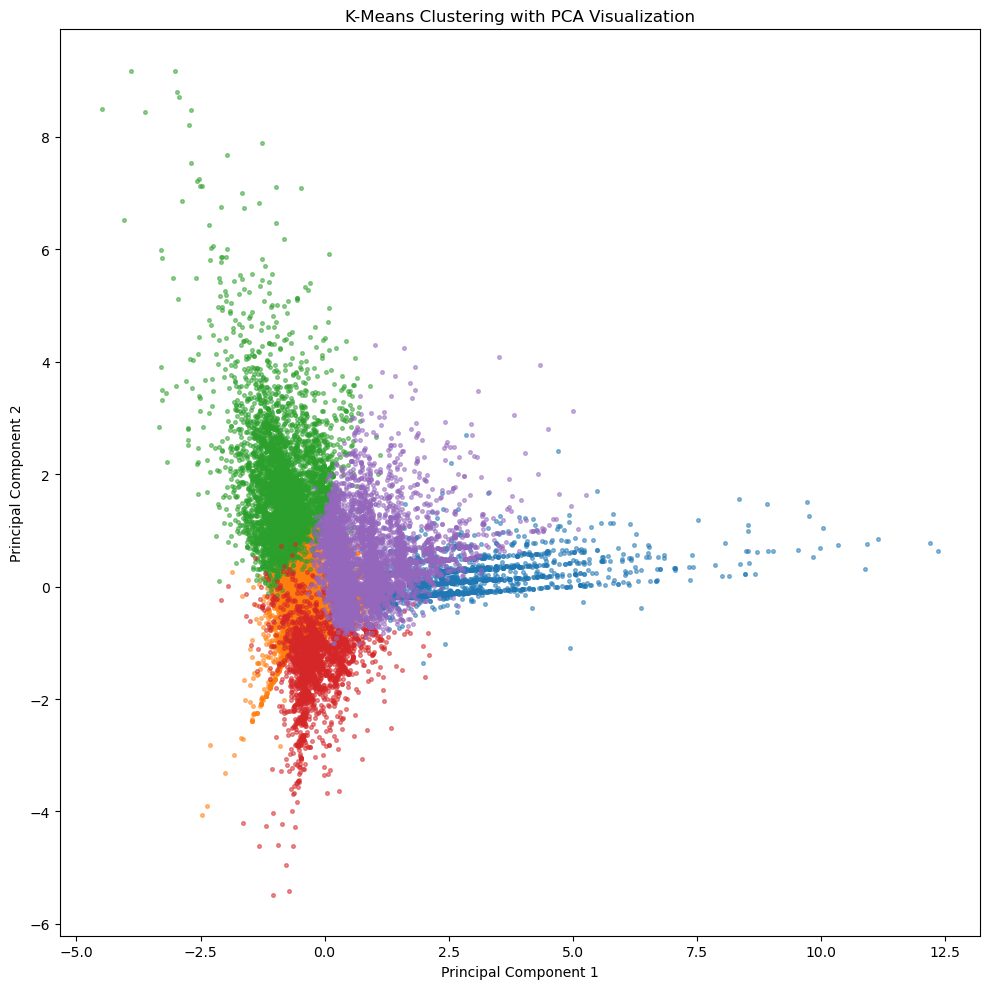

In [ ]:
from sklearn.decomposition import PCA

flattened_data = super_mat.reshape(len(super_mat), -1)

# K-Means Clustering -> Set k=5 -> Five clusters
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(flattened_data)

# For the PCA visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(flattened_data)

labels = kmeans.labels_

plt.figure(figsize=(10, 10))
for i in range(k):
    plt.scatter(pca_result[labels == i, 0], pca_result[labels == i, 1], label=f'Cluster {i}', s=7, alpha=0.5)
    # plt.scatter(pca_result[labels == i, 0], pca_result[labels == i, 1], label=f'Cluster {i}', alpha=0.5)
plt.title('K-Means Clustering with PCA Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
# plt.legend(fontsize=30)
# plt.show()
plt.tight_layout()
plt.savefig('K-means_Clustering-V1.pdf')


In [ ]:
# 3D visualization with plotly
# You need to install plotly package
import plotly.express as px
import plotly.graph_objs as go

fig = go.Figure()
for cluster_label in range(k):
    cluster_points = transformed_data[labels == cluster_label]
    if cluster_label == 4:
        fig.add_trace(go.Scatter3d(x=cluster_points[:,0], y=cluster_points[:,1], z=cluster_points[:,2], marker=dict(size=3, opacity=0.2), mode='markers'))
    else:
        fig.add_trace(go.Scatter3d(x=cluster_points[:,0], y=cluster_points[:,1], z=cluster_points[:,2], marker=dict(size=3, opacity=0.5), mode='markers'))

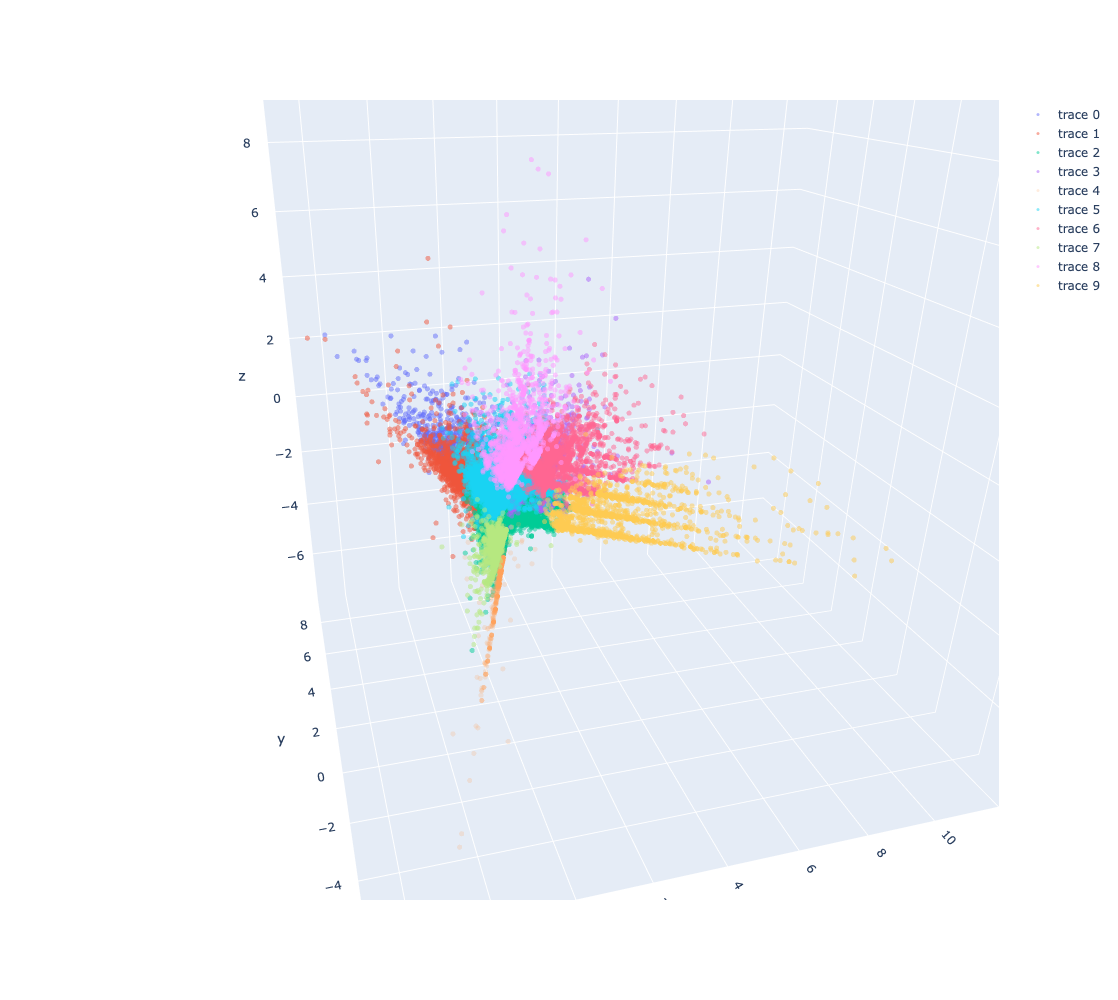

In [ ]:
fig.update_layout(
    autosize=False,
    width=1000,
    height=1000,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    ),
)
fig.show()

## Shard Non-IID

In [ ]:
# Shard based Non-IID split
total_users = 100 # Number of Users
ratios = [(sum(labels==i)) / len(labels) for i in range(k)]
users_per_group = np.array(ratios) * total_users
users_per_group = np.round(users_per_group).astype(int)

while users_per_group.sum() != total_users:
    diff = total_users - users_per_group.sum()
    max_idx = np.argmax(ratios) if diff > 0 else np.argmin(ratios)
    users_per_group[max_idx] += np.sign(diff)

label_prac_dataset = [[] for i in range(k)]

for data, cluster in zip(train_data, labels):
    label_prac_dataset[cluster].append(data)

In [ ]:
folder_path = '../FL_DATA_SPLIT/Super_cluster_'+ str(k) +'_nonIID/'
os.makedirs(folder_path, exist_ok=True)

random.seed(42)

past_num_user = 0
for cluster, num_user in enumerate(users_per_group):
    temp_list = label_prac_dataset[cluster]
    random.shuffle(temp_list)
    splited_datas = np.array_split(temp_list, num_user)

    for idx, splited_data in enumerate(splited_datas):
        json_data['data'] = list(splited_data)
        file_path = os.path.join(folder_path, f'User{idx+past_num_user}.json')
        with open(file_path, 'w') as outfile:
            json.dump(json_data, outfile)
    past_num_user += num_user

## Shard IID

In [ ]:
# Shard based IID split
total_users = 100 # Number of Users

user_dataset = [[] for i in range(total_users)]

for cluster in range(k):
    temp_list = label_prac_dataset[cluster]
    random.shuffle(temp_list)
    splited_datas = np.array_split(temp_list, total_users)
    for idx, datas in enumerate(splited_datas):
        user_dataset[idx].extend(list(datas))

folder_path = '../FL_DATA_SPLIT/Super_cluster_'+ str(k) +'_IID/'
os.makedirs(folder_path, exist_ok=True)

for idx, user_data in enumerate(user_dataset):
        json_data['data'] = list(user_data)
        file_path = os.path.join(folder_path, f'User{idx}.json')
        with open(file_path, 'w') as outfile:
            json.dump(json_data, outfile)

## Full dataset (For Centralized Learning)

In [ ]:
mini_data=[]
for cluster in range(k):
    temp_list = label_prac_dataset[cluster]
    random.shuffle(temp_list)
    mini_data.extend(temp_list[:2282])

json_data['data'] = list(mini_data)
file_path = '../FL_DATA_SPLIT/mini_Super_cluster_'+ str(k) +'_Full.json'
with open(file_path, 'w') as outfile:
    json.dump(json_data, outfile)

## Random

In [ ]:
random.shuffle(mini_data)
splited_datas = np.array_split(mini_data, total_users)
folder_path = '../FL_DATA_SPLIT/mini_Random'
os.makedirs(folder_path, exist_ok=True)
for idx, splited_data in enumerate(splited_datas):
    json_data['data'] = list(splited_data)
    file_path = os.path.join(folder_path, f'User{idx}.json')
    with open(file_path, 'w') as outfile:
        json.dump(json_data, outfile)

## Dirichlet dist. based split

In [ ]:
def client_inner_dirichlet_partition(targets, num_clients, dir_alpha, client_sample_nums, verbose=True):
    """Non-iid Dirichlet partition.

    The method is from The method is from paper `Federated Learning Based on Dynamic Regularization <https://openreview.net/forum?id=B7v4QMR6Z9w>`_.
    This function can be used by given specific sample number for all clients ``client_sample_nums``.
    It's different from :func:`hetero_dir_partition`.

    Args:
        targets (list or numpy.ndarray): Sample targets.
        num_clients (int): Number of clients for partition.
        num_classes (int): Number of classes in samples.
        dir_alpha (float): Parameter alpha for Dirichlet distribution.
        client_sample_nums (numpy.ndarray): A numpy array consisting ``num_clients`` integer elements, each represents sample number of corresponding clients.
        verbose (bool, optional): Whether to print partition process. Default as ``True``.

    Returns:
        dict: ``{ client_id: indices}``.

    """
    if not isinstance(targets, np.ndarray):
        data = np.array(targets[0])
        cluster = np.array(targets[1])

    num_classes = 5

    class_priors = np.random.dirichlet(alpha=[dir_alpha] * num_classes,
                                       size=num_clients)
    prior_cumsum = np.cumsum(class_priors, axis=1)
    idx_list = [np.where(cluster == i)[0] for i in range(num_classes)]
    class_amount = [len(idx_list[i]) for i in range(num_classes)]

    client_indices = [np.zeros(client_sample_nums[cid]).astype(np.int64) for cid in
                      range(num_clients)]

    while np.sum(client_sample_nums) != 0:
        curr_cid = np.random.randint(num_clients)
        # If current node is full resample a client
        if verbose:
            os.system('cls' if os.name == 'nt' else 'clear')
            print('Remaining Data: %d' % np.sum(client_sample_nums))
        if client_sample_nums[curr_cid] <= 0:
            continue
        client_sample_nums[curr_cid] -= 1
        curr_prior = prior_cumsum[curr_cid]
        while True:
            curr_class = np.argmax(np.random.uniform() <= curr_prior)
            # Redraw class label if no rest in current class samples
            if class_amount[curr_class] <= 0:
                continue
            class_amount[curr_class] -= 1
            client_indices[curr_cid][client_sample_nums[curr_cid]] = \
                idx_list[curr_class][class_amount[curr_class]]

            break

    client_dict = {cid: data[client_indices[cid]] for cid in range(num_clients)}
    label_dict = {cid: cluster[client_indices[cid]] for cid in range(num_clients)}
    return client_dict, label_dict

In [ ]:
mini_prac = [[],[]]
for cluster in range(k):
    temp_list = label_prac_dataset[cluster]
    random.shuffle(temp_list)
    for i in range(2282):
        mini_prac[0].append(temp_list[i])
        mini_prac[1].append(cluster)

In [ ]:
diri_data_02, diri_data_02_cl = client_inner_dirichlet_partition(mini_prac, 100, 0.2, [114 if i > 9 else 115 for i in range(100)])
diri_data_1, diri_data_1_cl = client_inner_dirichlet_partition(mini_prac, 100, 1, [114 if i > 9 else 115 for i in range(100)])
diri_data_10, diri_data_10_cl = client_inner_dirichlet_partition(mini_prac, 100, 10, [114 if i > 9 else 115 for i in range(100)])

In [ ]:
print(np.unique(diri_data_02_cl[6], return_counts=True))
print(np.unique(diri_data_1_cl[2], return_counts=True))
print(np.unique(diri_data_10_cl[3], return_counts=True))

In [ ]:
folder_path = '../FL_DATA_SPLIT/mini_Super_cluster_'+ str(k) +'_Diri_02/'
os.makedirs(folder_path, exist_ok=True)

for idx in range(100):
        json_data['data'] = list(diri_data_02[idx])
        file_path = os.path.join(folder_path, f'User{idx}.json')
        with open(file_path, 'w') as outfile:
            json.dump(json_data, outfile)

In [ ]:
folder_path = '../FL_DATA_SPLIT/mini_Super_cluster_'+ str(k) +'_Diri_1/'
os.makedirs(folder_path, exist_ok=True)

for idx in range(100):
        json_data['data'] = list(diri_data_1[idx])
        file_path = os.path.join(folder_path, f'User{idx}.json')
        with open(file_path, 'w') as outfile:
            json.dump(json_data, outfile)

In [ ]:
folder_path = '../FL_DATA_SPLIT/mini_Super_cluster_'+ str(k) +'_Diri_10/'
os.makedirs(folder_path, exist_ok=True)

for idx in range(100):
        json_data['data'] = list(diri_data_10[idx])
        file_path = os.path.join(folder_path, f'User{idx}.json')
        with open(file_path, 'w') as outfile:
            json.dump(json_data, outfile)